#Setup environment 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import os
import datetime
import numpy as np

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG16
from keras.regularizers import l2
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import itertools
from PIL import Image


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import class_weight


2.4.0


In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

# **4.1: TRAIN A NETWORK FOR MASSES AND CALCIFICATION EXPLOITING BASELINE PATCHES**



## Prepare Input

### Function to pair baselines and abnormalities

In [ ]:
def make_pairs(images,labels):
  pairimg=[]
  pairlabel=[]
  for i in range(0,(len(images)//2)):
    pairimg.append([images[2*i+1]/65535,images[2*i]/65535])
    pairlabel.append(labels[2*i+1])
  return (np.array(pairimg), np.array(pairlabel))

### Prepare Train set





In [ ]:
#Load learning sets
import numpy as np
out_path = '/content/gdrive/My Drive/Balestri_Silvestri/numpy data'

def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

def load_test():
  images = np.load(os.path.join(out_path,'public_test_tensor.npy'))
  labels = np.load(os.path.join(out_path,'public_test_labels.npy'))
  return images,labels
grayscale_images, labels= load_training()
images = np.repeat(grayscale_images[..., np.newaxis], 3, -1)
print("Training set loaded")
print("Images:" + str(np.shape(images)))
print("Labels:" + str(np.shape(labels)))
print() 

test_images_imp, test_labels_imp = load_test()
test_images_imp = np.repeat(test_images_imp[..., np.newaxis], 3, -1)
print("Test set loaded")
print("Test Images:" + str(np.shape(test_images_imp)))
print("Test Labels:" +str(np.shape(test_labels_imp)))

Training set loaded
Images:(5352, 150, 150, 3)
Labels:(5352,)

Test set loaded
Test Images:(672, 150, 150, 3)
Test Labels:(672,)


In [ ]:
#TRAIN/VALIDATION SET
#Build pairs
abn_images,abn_labels=make_pairs(images,labels)

#Change labels according to Mass and Calcification
abn_labels = np.where(np.logical_or(abn_labels == 1, abn_labels == 2), 0, abn_labels)
abn_labels = np.where(np.logical_or(abn_labels == 3, abn_labels == 4), 1, abn_labels)

#Split between training and validation
train_images, validation_images, train_labels, validation_labels = train_test_split(abn_images, abn_labels, test_size=0.2, shuffle= True)
total_train=np.size(train_images,0)
train_class0 = (train_labels == 0).sum()
train_class1 = (train_labels == 1).sum()
total_val=np.size(validation_images,0)
validation_class0 = (validation_labels == 0).sum()
validation_class1 = (validation_labels == 1).sum()


print("Training/Validation set split.")
print("Train Images:" + str(np.shape(train_images)))
print("Train Labels:" + str(np.shape(train_labels)))
print (str(train_class0) + " belonging to class 0 in the training set")
print (str(train_class1) + " belonging to class 1 in the training set")
print()
print("Validation Images:" + str(np.shape(validation_images)))
print("Validation Labels:" + str(np.shape(validation_labels)))
print (str(validation_class0) + " belonging to class 0 in the validation set")
print (str(validation_class1) + " belonging to class 1 in the validation set")

Training/Validation set split.
Train Images:(2140, 2, 150, 150, 3)
Train Labels:(2140,)
983 belonging to class 0 in the training set
1157 belonging to class 1 in the training set

Validation Images:(536, 2, 150, 150, 3)
Validation Labels:(536,)
235 belonging to class 0 in the validation set
301 belonging to class 1 in the validation set


### Prepare Test set

In [ ]:
#TEST SET
#Build pairs
test_images,test_labels=make_pairs(test_images_imp,test_labels_imp)

#Change labels according to Mass and Calcification
test_labels = np.where(np.logical_or(test_labels == 1, test_labels == 2), 0, test_labels)
test_labels = np.where(np.logical_or(test_labels == 3, test_labels == 4), 1, test_labels)

test_class0 = (test_labels == 0).sum()
test_class1 = (test_labels == 1).sum()

print("Test Set")
print("Test Images:" + str(np.shape(test_images)))
print("Test Labels:" + str(np.shape(test_labels)))
print (str(test_class0) + " belonging to class 0 in the test set")
print (str(test_class1) + " belonging to class 1 in the test set")


Test Set
Test Images:(336, 2, 150, 150, 3)
Test Labels:(336,)
179 belonging to class 0 in the test set
157 belonging to class 1 in the test set


###Data Preprocessing

In [ ]:
#Data Preprocessing
BATCH_SIZE = 32

## Usage of Twin VGG16 Networks to subtract baseline features from abnormalities

In [ ]:
vgg16=tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(150,150,3))
vgg16.trainable=False
abn_input=Input(shape=(150,150,3))
base_input=Input(shape=(150,150,3))

abn_feats=vgg16(abn_input)
base_feats=vgg16(base_input)
subtr=Subtract()([abn_feats,base_feats])
flt=Flatten()(subtr)
densel=Dense(512,activation='relu')(flt)
drop = Dropout(0.2)(densel)
prediction = Dense(1,activation='sigmoid')(drop)
model = Model(inputs=[abn_input,base_input],outputs=prediction)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
network_name = 'VGG16_baseline_2.h5'
network_name_best = 'VGG16_baseline_2_best.h5'
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['acc'])


CHECKPOINT_PATH = '/content/gdrive/My Drive/Balestri_Silvestri/models/Baseline_CNN_mass_calc/' + network_name_best

my_callback = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 5),
        tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor = "val_loss", mode='auto', save_best_only=True)
]

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 4, 4, 512)    14714688    input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
subtract (Subtract)             (None, 4, 4, 512)    0           vgg16[0][0]                  

In [ ]:
history = model.fit(
      [train_images[:,0],train_images[:,1]],train_labels[:],
      batch_size = BATCH_SIZE,
      steps_per_epoch=total_train // BATCH_SIZE,
      epochs=100,
      validation_data = ([validation_images[:,0],validation_images[:,1]],validation_labels[:]),
      validation_steps=total_val // BATCH_SIZE,
      callbacks=[my_callback]
      )

Epoch 1/100
66/66 [==============================] - 20s 163ms/step - loss: 0.6191 - acc: 0.7246 - val_loss: 0.5020 - val_acc: 0.7852
Epoch 2/100
66/66 [==============================] - 11s 149ms/step - loss: 0.4641 - acc: 0.8147 - val_loss: 0.4517 - val_acc: 0.8047
Epoch 3/100
66/66 [==============================] - 10s 150ms/step - loss: 0.4022 - acc: 0.8457 - val_loss: 0.4274 - val_acc: 0.8105
Epoch 4/100
66/66 [==============================] - 10s 151ms/step - loss: 0.3399 - acc: 0.8819 - val_loss: 0.4153 - val_acc: 0.8203
Epoch 5/100
66/66 [==============================] - 10s 151ms/step - loss: 0.3156 - acc: 0.8905 - val_loss: 0.4084 - val_acc: 0.8203
Epoch 6/100
66/66 [==============================] - 10s 153ms/step - loss: 0.3036 - acc: 0.8734 - val_loss: 0.4047 - val_acc: 0.8125
Epoch 7/100
66/66 [==============================] - 10s 156ms/step - loss: 0.2903 - acc: 0.8888 - val_loss: 0.4005 - val_acc: 0.8184
Epoch 8/100
66/66 [==============================] - 10s 157ms

We can't preprocess images with the ImageDataGenerator, a solution could be a custom implementation of agumentation.<br>
We will try to increase the dropout to solve the overfitting.



In [ ]:
vgg16=tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(150,150,3))
vgg16.trainable=False
abn_input=Input(shape=(150,150,3))
base_input=Input(shape=(150,150,3))

abn_feats=vgg16(abn_input)
base_feats=vgg16(base_input)
subtr=Subtract()([abn_feats,base_feats])
flt=Flatten()(subtr)
densel=Dense(512,activation='relu')(flt)
drop = Dropout(0.8)(densel)
prediction = Dense(1,activation='sigmoid')(drop)
model = Model(inputs=[abn_input,base_input],outputs=prediction)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['acc'])


CHECKPOINT_PATH = '/content/gdrive/My Drive/Balestri_Silvestri/models/Baseline_CNN_mass_calc/' + network_name_best

my_callback = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 5),
        tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor = "val_loss", mode='auto', save_best_only=True)
]

In [ ]:
history = model.fit(
      [train_images[:,0],train_images[:,1]],train_labels[:],
      batch_size = BATCH_SIZE,
      steps_per_epoch=total_train // BATCH_SIZE,
      epochs=100,
      validation_data = ([validation_images[:,0],validation_images[:,1]],validation_labels[:]),
      validation_steps=total_val // BATCH_SIZE,
      callbacks=[my_callback]
      )

Epoch 1/100
66/66 [==============================] - 20s 163ms/step - loss: 0.6499 - acc: 0.6454 - val_loss: 0.5507 - val_acc: 0.7832
Epoch 2/100
66/66 [==============================] - 11s 153ms/step - loss: 0.5325 - acc: 0.7892 - val_loss: 0.4953 - val_acc: 0.7969
Epoch 3/100
66/66 [==============================] - 10s 156ms/step - loss: 0.4828 - acc: 0.8063 - val_loss: 0.4603 - val_acc: 0.8145
Epoch 4/100
66/66 [==============================] - 10s 157ms/step - loss: 0.4422 - acc: 0.8309 - val_loss: 0.4355 - val_acc: 0.8223
Epoch 5/100
66/66 [==============================] - 10s 159ms/step - loss: 0.3971 - acc: 0.8512 - val_loss: 0.4199 - val_acc: 0.8223
Epoch 6/100
66/66 [==============================] - 11s 161ms/step - loss: 0.3916 - acc: 0.8508 - val_loss: 0.4048 - val_acc: 0.8262
Epoch 7/100
66/66 [==============================] - 11s 164ms/step - loss: 0.3654 - acc: 0.8635 - val_loss: 0.3959 - val_acc: 0.8320
Epoch 8/100
66/66 [==============================] - 11s 167ms

### MODEL EVALUATION (VGG16-BL)

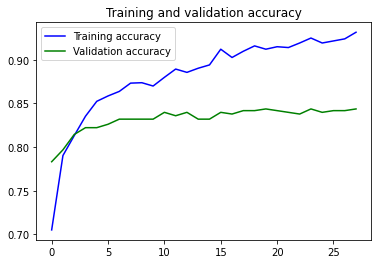

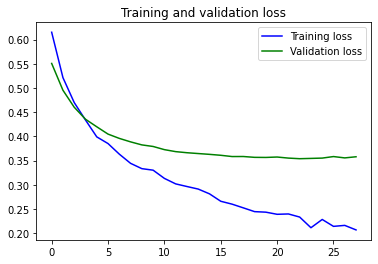

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

11/11 [==============================] - 3s 236ms/step - loss: 0.4068 - acc: 0.8244
0.824404776096344
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       179
           1       0.81      0.82      0.81       157

    accuracy                           0.82       336
   macro avg       0.82      0.82      0.82       336
weighted avg       0.82      0.82      0.82       336



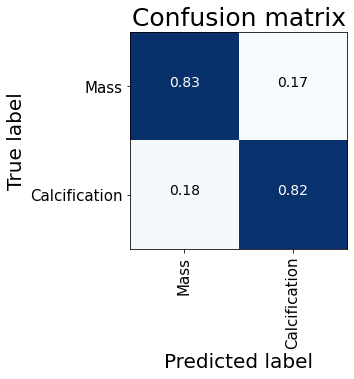

In [ ]:
test_loss, test_accuracy = model.evaluate([test_images[:,0],test_images[:,1]],test_labels)
print(test_accuracy)

pred_labels = (model.predict([test_images[:,0],test_images[:,1]]) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Mass','Calcification'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Baseline_CNN_mass_calc/"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, network_name))

11/11 [==============================] - 2s 123ms/step - loss: 0.4000 - acc: 0.8274
0.8273809552192688
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       179
           1       0.81      0.83      0.82       157

    accuracy                           0.83       336
   macro avg       0.83      0.83      0.83       336
weighted avg       0.83      0.83      0.83       336



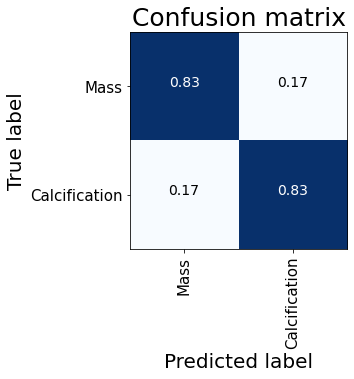

In [ ]:
#load and test the "best model" 
path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Baseline_CNN_mass_calc/"
model_best = keras.models.load_model(os.path.join(path, network_name_best))


test_loss, test_accuracy = model_best.evaluate([test_images[:,0],test_images[:,1]],test_labels)
print(test_accuracy)

pred_labels = (model_best.predict([test_images[:,0],test_images[:,1]]) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Mass','Calcification'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

# **4.2: TRAIN A NETWORK FOR BENIGN AND MALIGNANT EXPLOITING BASELINE PATCHES**



## Prepare Input

### Function to pair baselines and abnormalities

In [ ]:
def make_pairs(images,labels):
  pairimg=[]
  pairlabel=[]
  for i in range(0,(len(images)//2)):
    pairimg.append([images[2*i+1]/65535,images[2*i]/65535])
    pairlabel.append(labels[2*i+1])
  return (np.array(pairimg), np.array(pairlabel))

### Prepare Train set





In [ ]:
#Load learning sets
import numpy as np
out_path = '/content/gdrive/My Drive/Balestri_Silvestri/numpy data'

def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

def load_test():
  images = np.load(os.path.join(out_path,'public_test_tensor.npy'))
  labels = np.load(os.path.join(out_path,'public_test_labels.npy'))
  return images,labels
grayscale_images, labels= load_training()
images = np.repeat(grayscale_images[..., np.newaxis], 3, -1)
print("Training set loaded")
print("Images:" + str(np.shape(images)))
print("Labels:" + str(np.shape(labels)))
print() 

test_images_imp, test_labels_imp = load_test()
test_images_imp = np.repeat(test_images_imp[..., np.newaxis], 3, -1)
print("Test set loaded")
print("Test Images:" + str(np.shape(test_images_imp)))
print("Test Labels:" +str(np.shape(test_labels_imp)))

Training set loaded
Images:(5352, 150, 150, 3)
Labels:(5352,)

Test set loaded
Test Images:(672, 150, 150, 3)
Test Labels:(672,)


In [ ]:
#TRAIN/VALIDATION SET
#Build pairs
abn_images,abn_labels=make_pairs(images,labels)

#Change labels according to Mass and Calcification
abn_labels = np.where(np.logical_or(abn_labels == 1, abn_labels == 3), 1, abn_labels)
abn_labels = np.where(np.logical_or(abn_labels == 2, abn_labels == 4), 0, abn_labels)

#Split between training and validation
train_images, validation_images, train_labels, validation_labels = train_test_split(abn_images, abn_labels, test_size=0.2, shuffle= True)
total_train=np.size(train_images,0)
train_class0 = (train_labels == 0).sum()
train_class1 = (train_labels == 1).sum()
total_val=np.size(validation_images,0)
validation_class0 = (validation_labels == 0).sum()
validation_class1 = (validation_labels == 1).sum()


print("Training/Validation set split.")
print("Train Images:" + str(np.shape(train_images)))
print("Train Labels:" + str(np.shape(train_labels)))
print (str(train_class0) + " belonging to class 0 in the training set")
print (str(train_class1) + " belonging to class 1 in the training set")
print()
print("Validation Images:" + str(np.shape(validation_images)))
print("Validation Labels:" + str(np.shape(validation_labels)))
print (str(validation_class0) + " belonging to class 0 in the validation set")
print (str(validation_class1) + " belonging to class 1 in the validation set")

Training/Validation set split.
Train Images:(2140, 2, 150, 150, 3)
Train Labels:(2140,)
897 belonging to class 0 in the training set
1243 belonging to class 1 in the training set

Validation Images:(536, 2, 150, 150, 3)
Validation Labels:(536,)
211 belonging to class 0 in the validation set
325 belonging to class 1 in the validation set


### Prepare Test set

In [ ]:
#TEST SET
#Build pairs
test_images,test_labels=make_pairs(test_images_imp,test_labels_imp)

#Change labels according to Mass and Calcification
test_labels = np.where(np.logical_or(test_labels == 1, test_labels == 3), 1, test_labels)
test_labels = np.where(np.logical_or(test_labels == 2, test_labels == 4), 0, test_labels)

test_class0 = (test_labels == 0).sum()
test_class1 = (test_labels == 1).sum()

print("Test Set")
print("Test Images:" + str(np.shape(test_images)))
print("Test Labels:" + str(np.shape(test_labels)))
print (str(test_class0) + " belonging to class 0 in the test set")
print (str(test_class1) + " belonging to class 1 in the test set")


Test Set
Test Images:(336, 2, 150, 150, 3)
Test Labels:(336,)
117 belonging to class 0 in the test set
219 belonging to class 1 in the test set


###Data Preprocessing

In [ ]:
#Data Preprocessing
BATCH_SIZE = 32

## Usage of Twin VGG16 Networks to subtract baseline features from abnormalities

In [ ]:
vgg16=tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(150,150,3))
vgg16.trainable=False
abn_input=Input(shape=(150,150,3))
base_input=Input(shape=(150,150,3))

abn_feats=vgg16(abn_input)
base_feats=vgg16(base_input)
subtr=Subtract()([abn_feats,base_feats])
flt=Flatten()(subtr)
densel=Dense(512,activation='relu')(flt)
drop = Dropout(0.8)(densel)
prediction = Dense(1,activation='sigmoid')(drop)
model = Model(inputs=[abn_input,base_input],outputs=prediction)

In [ ]:
network_name = 'VGG16_baseline_3.h5'
network_name_best = 'VGG16_baseline_3_best.h5'
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['acc'])


CHECKPOINT_PATH = '/content/gdrive/My Drive/Balestri[_Silvestri]/models/Baseline_CNN_ben_mal/' + network_name_best

my_callback = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 5),
        tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor = "val_loss", mode='auto', save_best_only=True)
]

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 4, 4, 512)    14714688    input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
subtract (Subtract)             (None, 4, 4, 512)    0           vgg16[0][0]                  

In [ ]:
history = model.fit(
      [train_images[:,0],train_images[:,1]],train_labels[:],
      batch_size = BATCH_SIZE,
      steps_per_epoch=total_train // BATCH_SIZE,
      epochs=100,
      validation_data = ([validation_images[:,0],validation_images[:,1]],validation_labels[:]),
      validation_steps=total_val // BATCH_SIZE,
      callbacks=[my_callback]
      )

Epoch 1/100
66/66 [==============================] - 21s 174ms/step - loss: 0.6679 - acc: 0.5750 - val_loss: 0.6235 - val_acc: 0.6562
Epoch 2/100
66/66 [==============================] - 13s 167ms/step - loss: 0.6096 - acc: 0.6486 - val_loss: 0.6084 - val_acc: 0.6562
Epoch 3/100
66/66 [==============================] - 11s 171ms/step - loss: 0.6002 - acc: 0.6680 - val_loss: 0.6004 - val_acc: 0.6719
Epoch 4/100
66/66 [==============================] - 12s 177ms/step - loss: 0.5731 - acc: 0.6974 - val_loss: 0.5926 - val_acc: 0.6582
Epoch 5/100
66/66 [==============================] - 12s 180ms/step - loss: 0.5599 - acc: 0.7119 - val_loss: 0.5881 - val_acc: 0.6621
Epoch 6/100
66/66 [==============================] - 11s 172ms/step - loss: 0.5606 - acc: 0.7158 - val_loss: 0.5839 - val_acc: 0.6699
Epoch 7/100
66/66 [==============================] - 11s 170ms/step - loss: 0.5590 - acc: 0.7053 - val_loss: 0.5826 - val_acc: 0.6738
Epoch 8/100
66/66 [==============================] - 11s 170ms

### MODEL EVALUATION (VGG16-BL)

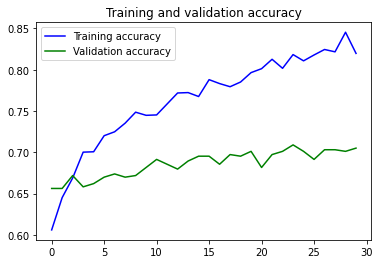

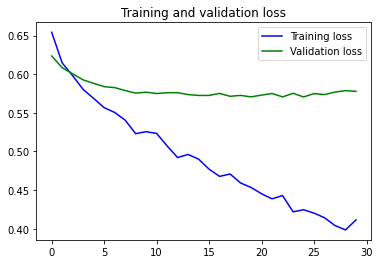

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

11/11 [==============================] - 3s 233ms/step - loss: 0.6330 - acc: 0.6369
0.636904776096344
              precision    recall  f1-score   support

           0       0.48      0.54      0.51       117
           1       0.74      0.69      0.71       219

    accuracy                           0.64       336
   macro avg       0.61      0.61      0.61       336
weighted avg       0.65      0.64      0.64       336



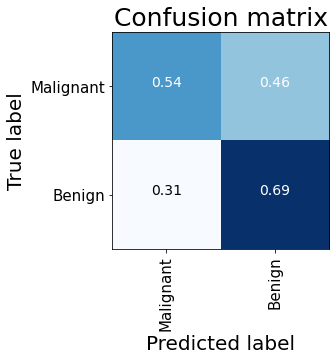

In [ ]:
test_loss, test_accuracy = model.evaluate([test_images[:,0],test_images[:,1]],test_labels)
print(test_accuracy)

pred_labels = (model.predict([test_images[:,0],test_images[:,1]]) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri[_Silvestri]/models/Baseline_CNN_ben_mal/"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, network_name))

11/11 [==============================] - 2s 130ms/step - loss: 0.6328 - acc: 0.6161
0.6160714030265808
              precision    recall  f1-score   support

           0       0.45      0.51      0.48       117
           1       0.72      0.67      0.70       219

    accuracy                           0.62       336
   macro avg       0.59      0.59      0.59       336
weighted avg       0.63      0.62      0.62       336



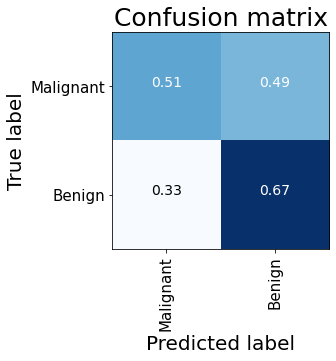

In [ ]:
#load and test the "best model" 
path = "/content/gdrive/My Drive/Balestri[_Silvestri]/models/Baseline_CNN_ben_mal/"
model_best = keras.models.load_model(os.path.join(path, network_name_best))


test_loss, test_accuracy = model_best.evaluate([test_images[:,0],test_images[:,1]],test_labels)
print(test_accuracy)

pred_labels = (model_best.predict([test_images[:,0],test_images[:,1]]) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))